In [30]:
import numpy as np
import pickle
import math
from scipy.stats import sem
import matplotlib.pyplot as plt
import pandas as pd
import time
import pprint
import seaborn as sns
import statsmodels.formula.api as smf
import CMR_IA as cmr
import scipy as sp
sns.set_context('paper')
plt.style.use('default')
pd.set_option('display.max_columns', None)

In [31]:
with open("../Data/simu8b_design.pkl", 'rb') as inp:
    df_study = pickle.load(inp)
    df_test = pickle.load(inp)
# df_study = df_study.loc[df_study.session < 1000]
# df_test = df_test.loc[df_test.session < 1000]

In [32]:
df_study

,study_itemno1,study_itemno2,study_item1,study_item2,serial_pos,list,session
0,12,24,Face12,Joe,0,0,0
1,2,29,Face2,Mark,1,0,0
2,6,27,Face6,Dan,2,0,0
3,13,18,Face13,John,3,0,0
4,11,31,Face11,George,4,0,0
...,...,...,...,...,...,...,...
79995,8,30,Face8,Mike,3,0,9999
79996,9,24,Face9,Joe,4,0,9999
79997,7,28,Face7,Paul,5,0,9999
79998,16,23,Face16,Charles,6,0,9999


In [33]:
df_test

,test_itemno,test_item,correct_ans,study_pos,list,session
0,1,Face1,30,6,0,0
1,2,Face2,29,1,0,0
2,6,Face6,27,2,0,0
3,14,Face14,22,7,0,0
4,13,Face13,18,3,0,0
...,...,...,...,...,...,...
79995,1,Face1,20,1,0,9999
79996,15,Face15,25,0,0,9999
79997,8,Face8,30,3,0,9999
79998,16,Face16,23,6,0,9999


### Distance

In [34]:
face_distance = np.load('../Data/simu8_distance.npy')

In [35]:
def get_distance(df_tmp):
    faces = np.unique(df_tmp.test_itemno)
    face_dist = {}
    for face in faces:
        this_dist = []
        for other_face in faces:
            if face != other_face:
                this_dist.append(face_distance[face-1,other_face-1])
        this_dist = np.array(this_dist)
        face_dist[face] = this_dist
    y = df_tmp.apply(lambda x: face_dist[x['test_itemno']],axis=1)
    return y
df_test['distance'] = df_test.groupby("session").apply(get_distance).to_frame(name='distance').reset_index()['distance']
df_test

,test_itemno,test_item,correct_ans,study_pos,list,session,distance
0,1,Face1,30,6,0,0,"[1.0709, 2.202, 2.2233, 3.2373, 3.5772, 2.8095..."
1,2,Face2,29,1,0,0,"[1.0709, 2.0108, 2.4045, 3.7211, 3.5024, 2.597..."
2,6,Face6,27,2,0,0,"[2.202, 2.0108, 3.194, 2.8217, 3.9032, 1.6004,..."
3,14,Face14,22,7,0,0,"[2.9509, 2.9187, 2.4855, 1.8175, 2.3944, 3.368..."
4,13,Face13,18,3,0,0,"[2.8095, 2.5971, 1.6004, 2.5139, 2.5733, 3.678..."
...,...,...,...,...,...,...,...
79995,1,Face1,20,1,0,9999,"[2.1647, 2.202, 2.8935, 2.2233, 3.5825, 3.9391..."
79996,15,Face15,25,0,0,9999,"[3.9391, 3.1458, 3.3766, 2.4733, 3.4689, 1.838..."
79997,8,Face8,30,3,0,9999,"[2.2233, 2.4245, 3.194, 3.508, 3.4755, 3.4689,..."
79998,16,Face16,23,6,0,9999,"[4.0651, 3.4535, 3.3654, 2.7967, 3.2039, 2.360..."


In [36]:
distance_thresh = 3
df_test['neighbour'] = df_test.apply(lambda x: sum(x['distance'] < distance_thresh), axis=1)
df_test['neighbour_group'] = df_test.apply(lambda x: 6 if x['neighbour'] == 7 else x['neighbour'], axis=1)
series_distance = df_test['distance']
df_test.drop('distance', axis=1, inplace=True)
df_test

,test_itemno,test_item,correct_ans,study_pos,list,session,neighbour,neighbour_group
0,1,Face1,30,6,0,0,5,5
1,2,Face2,29,1,0,0,5,5
2,6,Face6,27,2,0,0,5,5
3,14,Face14,22,7,0,0,6,6
4,13,Face13,18,3,0,0,6,6
...,...,...,...,...,...,...,...,...
79995,1,Face1,20,1,0,9999,4,4
79996,15,Face15,25,0,0,9999,3,3
79997,8,Face8,30,3,0,9999,2,2
79998,16,Face16,23,6,0,9999,3,3


In [37]:
df_test.groupby('neighbour')['neighbour'].count()

neighbour
0      229
1     2560
2     9942
3    20758
4    24779
5    16382
6     4906
7      444
Name: neighbour, dtype: int64

### Run CMR-IA

In [38]:
s_mat = np.load('../Data/simu8_smat.npy')

In [39]:
params = cmr.make_default_params()
params.update(
    beta_enc = 0.5,
    beta_rec = 0.7, # overall accuracy important
    beta_rec_new = 0.1,
    beta_rec_post = 0.1,
    gamma_fc = 0.4,
    gamma_cf = 0.6, # unknown why
    s_fc = 0.4,
    s_cf = 0.6, # s_cf > s_fc
    c_thresh = 0.01,
    c_thresh_ass = 0.01,
    a = 2800,
    b = 2.14,
    m = 0,
    n = 1,
    kappa = 0.08,
    lamb = 0.04,
    eta = 0.01,
    alpha = 0.5,
    omega = 2,
    phi_s = 1,
    phi_d = 0.6,
    nitems_in_accumulator = 16, # must be 16
    d_ass = 0.6, # overall accuracy important
    No_recall = np.arange(0,8),
)
params

{'beta_enc': 0.5,
 'beta_rec': 0.7,
 'beta_rec_new': 0.1,
 'beta_rec_post': 0.1,
 'beta_distract': None,
 'phi_s': 1,
 'phi_d': 0.6,
 's_cf': 0.6,
 's_fc': 0.4,
 'kappa': 0.08,
 'eta': 0.01,
 'omega': 2,
 'alpha': 0.5,
 'c_thresh': 0.01,
 'c_thresh_ass': 0.01,
 'd_ass': 0.6,
 'lamb': 0.04,
 'rec_time_limit': 60000.0,
 'dt': 10,
 'nitems_in_accumulator': 16,
 'max_recalls': 50,
 'learn_while_retrieving': False,
 'a': 2800,
 'b': 2.14,
 'm': 0,
 'n': 1,
 'c1': 0,
 'No_recall': array([0, 1, 2, 3, 4, 5, 6, 7]),
 'gamma_fc': 0.4,
 'gamma_cf': 0.6}

In [40]:
df_simu, f_in = cmr.run_intrusion_cr_multi_sess(params,df_study, df_test ,s_mat)
df_simu

CMR2 Time: 82.79094290733337


,list,session,test_itemno,s_resp,s_rt,csim
0,0,0,1,30.0,1320.0,0.784201
1,0,0,2,22.0,1760.0,0.522945
2,0,0,6,18.0,1800.0,0.515219
3,0,0,14,31.0,2150.0,0.515939
4,0,0,13,30.0,2820.0,0.525912
...,...,...,...,...,...,...
79995,0,9999,1,28.0,2050.0,0.494485
79996,0,9999,15,25.0,1880.0,0.521044
79997,0,9999,8,30.0,2110.0,0.710401
79998,0,9999,16,23.0,1500.0,0.729675


In [41]:
df_simu = df_simu.merge(df_test,on=['session','list','test_itemno'])
df_simu['correct'] = df_simu.s_resp == df_simu.correct_ans
df_simu['ITI'] = df_simu.apply(lambda x: True if x['correct'] == False and 17 <= x['s_resp'] <= 32 else False, axis=1)
# df_simu

In [42]:
df_simu.head(16)

,list,session,test_itemno,s_resp,s_rt,csim,test_item,correct_ans,study_pos,neighbour,neighbour_group,correct,ITI
0,0,0,1,30.0,1320.0,0.784201,Face1,30,6,5,5,True,False
1,0,0,2,22.0,1760.0,0.522945,Face2,29,1,5,5,False,True
2,0,0,6,18.0,1800.0,0.515219,Face6,27,2,5,5,False,True
3,0,0,14,31.0,2150.0,0.515939,Face14,22,7,6,6,False,True
4,0,0,13,30.0,2820.0,0.525912,Face13,18,3,6,6,False,True
5,0,0,8,19.0,1730.0,0.733962,Face8,19,5,5,5,True,False
6,0,0,12,24.0,2490.0,0.524024,Face12,24,0,1,1,True,False
7,0,0,11,27.0,2290.0,0.416499,Face11,31,4,3,3,False,True
8,0,1,12,32.0,2440.0,0.599819,Face12,25,1,3,3,False,True
9,0,1,11,30.0,1660.0,0.714789,Face11,30,3,3,3,True,False


In [43]:
# correct rate
sum(df_simu.correct)/len(df_simu.correct)

0.64605

In [44]:
# np.array(f_in).shape

In [45]:
df_neighbour_group = df_simu.groupby("neighbour_group").correct.mean().reset_index()
df_neighbour_group

,neighbour_group,correct
0,0,0.737991
1,1,0.707031
2,2,0.688091
3,3,0.654639
4,4,0.636668
5,5,0.626785
6,6,0.603925


In [46]:
df_neighbour = df_simu.groupby("neighbour").correct.mean().reset_index()
df_neighbour

,neighbour,correct
0,0,0.737991
1,1,0.707031
2,2,0.688091
3,3,0.654639
4,4,0.636668
5,5,0.626785
6,6,0.606400
7,7,0.576577


In [47]:
df_simu.to_pickle("../Data/simu8_df_46.pkl")

### PLOT

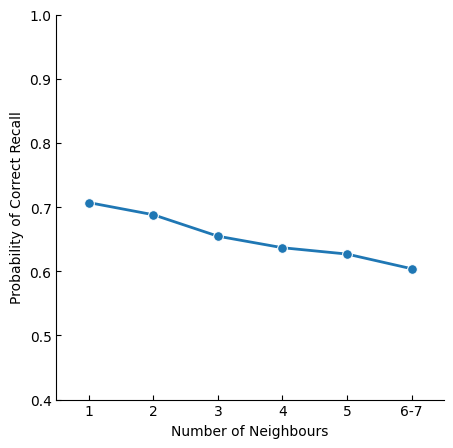

In [48]:
# neigbour group (as paper)
fig,ax = plt.subplots(figsize=(5,5))
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_neighbour_group.query("neighbour_group > 0"), x='neighbour_group', y='correct', linewidth=2, marker='o', markersize = 7)
plt.ylim([0.4,1])
plt.xlim([0.5,6.5])
plt.xticks(ticks=np.arange(1,7), labels=['1','2','3','4','5','6-7'])
plt.xlabel('Number of Neighbours')
plt.ylabel('Probability of Correct Recall')
plt.savefig('fig/simu8_correct_neighbourgroup.pdf')
plt.show()

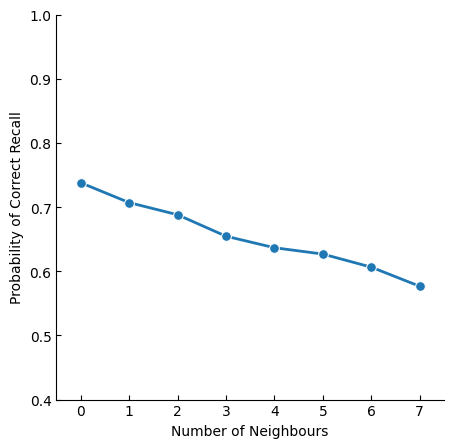

In [49]:
# neighbour
fig,ax = plt.subplots(figsize=(5,5))
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_neighbour, x='neighbour', y='correct', linewidth=2, marker='o', markersize = 7)
plt.ylim([0.4,1])
plt.xlim([-0.5,7.5])
plt.xlabel('Number of Neighbours')
plt.ylabel('Probability of Correct Recall')
plt.savefig('fig/simu8_correct_neighbour.pdf')
plt.show()

In [50]:
df_ILI = df_simu.loc[df_simu.ITI == True,:].copy()
df_ILI

,list,session,test_itemno,s_resp,s_rt,csim,test_item,correct_ans,study_pos,neighbour,neighbour_group,correct,ITI
1,0,0,2,22.0,1760.0,0.522945,Face2,29,1,5,5,False,True
2,0,0,6,18.0,1800.0,0.515219,Face6,27,2,5,5,False,True
3,0,0,14,31.0,2150.0,0.515939,Face14,22,7,6,6,False,True
4,0,0,13,30.0,2820.0,0.525912,Face13,18,3,6,6,False,True
7,0,0,11,27.0,2290.0,0.416499,Face11,31,4,3,3,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79982,0,9997,3,30.0,2380.0,0.517345,Face3,22,3,2,2,False,True
79983,0,9997,4,18.0,2720.0,0.448304,Face4,30,2,3,3,False,True
79985,0,9998,10,21.0,1890.0,0.537666,Face10,24,3,4,4,False,True
79990,0,9998,3,24.0,1700.0,0.520270,Face3,18,2,2,2,False,True


In [51]:
df_ILI_neighbour = df_ILI.query("neighbour > 0").groupby("neighbour_group")['test_item'].count().to_frame(name='ILI_cnt').reset_index()
df_ILI_neighbour['neighbour_cnt'] = df_simu.groupby("neighbour_group")['test_item'].count()[1:].to_list()
df_ILI_neighbour['ILI_prob'] = df_ILI_neighbour['ILI_cnt'] / df_ILI_neighbour['neighbour_cnt']
df_ILI_neighbour

,neighbour_group,ILI_cnt,neighbour_cnt,ILI_prob
0,1,750,2560,0.292969
1,2,3101,9942,0.311909
2,3,7169,20758,0.345361
3,4,9003,24779,0.363332
4,5,6114,16382,0.373215
5,6,2119,5350,0.396075


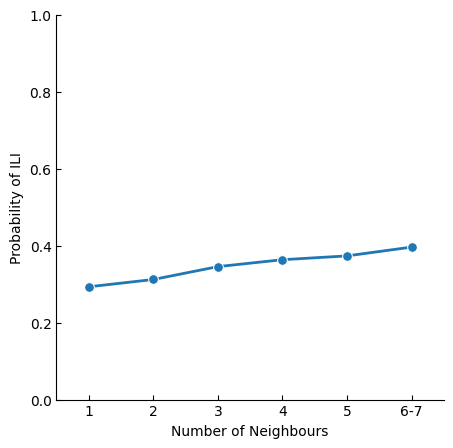

In [52]:
# ILI by neighbour
fig,ax = plt.subplots(figsize=(5,5))
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_ILI_neighbour.query("neighbour_group > 0"), x='neighbour_group', y='ILI_prob', linewidth=2, marker='o', markersize = 7)
plt.ylim([0,1])
plt.xlim([0.5,6.5])
plt.xticks(ticks=np.arange(1,7), labels=['1','2','3','4','5','6-7'])
plt.xlabel('Number of Neighbours')
plt.ylabel('Probability of ILI')
plt.savefig('fig/simu8_ILI_neighbourgroup.pdf')
plt.show()

In [53]:
def get_resp_face(df_tmp):
    sess = np.unique(df_tmp.session).item()
    sess_name_face = df_study.query(f"session == {sess}")[["study_itemno1","study_itemno2"]].set_index("study_itemno2").to_dict()['study_itemno1']
    resp_face = df_tmp.apply(lambda x: sess_name_face[x['s_resp']],axis=1)
    return resp_face

df_ILI['resp_face'] = df_ILI.groupby("session").apply(get_resp_face).to_frame().reset_index()[0].to_list()
df_ILI

,list,session,test_itemno,s_resp,s_rt,csim,test_item,correct_ans,study_pos,neighbour,neighbour_group,correct,ITI,resp_face
1,0,0,2,22.0,1760.0,0.522945,Face2,29,1,5,5,False,True,14
2,0,0,6,18.0,1800.0,0.515219,Face6,27,2,5,5,False,True,13
3,0,0,14,31.0,2150.0,0.515939,Face14,22,7,6,6,False,True,11
4,0,0,13,30.0,2820.0,0.525912,Face13,18,3,6,6,False,True,1
7,0,0,11,27.0,2290.0,0.416499,Face11,31,4,3,3,False,True,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79982,0,9997,3,30.0,2380.0,0.517345,Face3,22,3,2,2,False,True,4
79983,0,9997,4,18.0,2720.0,0.448304,Face4,30,2,3,3,False,True,13
79985,0,9998,10,21.0,1890.0,0.537666,Face10,24,3,4,4,False,True,5
79990,0,9998,3,24.0,1700.0,0.520270,Face3,18,2,2,2,False,True,10


In [54]:
df_ILI['resp_corr_distance'] = df_ILI.apply(lambda x: face_distance[x['test_itemno']-1,x['resp_face']-1], axis=1)
df_ILI['distance_bin'] = df_ILI.apply(lambda x: str(0.5 * (x['resp_corr_distance'] // 0.5 + 1)) if x['resp_corr_distance'] < 3.5 else ">3.5", axis=1)
df_ILI['distance'] = series_distance
df_ILI

,list,session,test_itemno,s_resp,s_rt,csim,test_item,correct_ans,study_pos,neighbour,neighbour_group,correct,ITI,resp_face,resp_corr_distance,distance_bin,distance
1,0,0,2,22.0,1760.0,0.522945,Face2,29,1,5,5,False,True,14,2.9187,3.0,"[1.0709, 2.0108, 2.4045, 3.7211, 3.5024, 2.597..."
2,0,0,6,18.0,1800.0,0.515219,Face6,27,2,5,5,False,True,13,1.6004,2.0,"[2.202, 2.0108, 3.194, 2.8217, 3.9032, 1.6004,..."
3,0,0,14,31.0,2150.0,0.515939,Face14,22,7,6,6,False,True,11,2.3944,2.5,"[2.9509, 2.9187, 2.4855, 1.8175, 2.3944, 3.368..."
4,0,0,13,30.0,2820.0,0.525912,Face13,18,3,6,6,False,True,1,2.8095,3.0,"[2.8095, 2.5971, 1.6004, 2.5139, 2.5733, 3.678..."
7,0,0,11,27.0,2290.0,0.416499,Face11,31,4,3,3,False,True,6,2.8217,3.0,"[3.2373, 3.7211, 2.8217, 3.0134, 3.2567, 2.573..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79982,0,9997,3,30.0,2380.0,0.517345,Face3,22,3,2,2,False,True,4,1.2474,1.5,"[1.2474, 3.3872, 3.3268, 2.1194, 3.4531, 3.160..."
79983,0,9997,4,18.0,2720.0,0.448304,Face4,30,2,3,3,False,True,13,3.8481,>3.5,"[1.2474, 3.4673, 2.367, 2.7036, 3.8481, 3.6034..."
79985,0,9998,10,21.0,1890.0,0.537666,Face10,24,3,4,4,False,True,5,3.4034,3.5,"[2.558, 2.8895, 3.4034, 3.4506, 2.7072, 3.0111..."
79990,0,9998,3,24.0,1700.0,0.520270,Face3,18,2,2,2,False,True,10,2.8895,3.0,"[2.9597, 3.3872, 3.2587, 3.3268, 2.8895, 3.145..."


In [55]:
distance_cnt = {}
for lst in df_ILI.distance:
    for d in lst:
        d_group = str(0.5 * (d // 0.5 + 1)) if d < 3.5 else ">3.5"
        if d_group in distance_cnt:
            distance_cnt[d_group] += 1
        else:
            distance_cnt[d_group] = 1
distance_cnt

{'1.5': 10661,
 '2.5': 37353,
 '>3.5': 33540,
 '3.0': 46135,
 '3.5': 56729,
 '2.0': 10231,
 '1.0': 3563}

In [56]:
df_ILI_distance = df_ILI.groupby("distance_bin")['test_itemno'].count().to_frame(name='ILI_cnt').reset_index()
df_ILI_distance['ILI_poss'] = df_ILI_distance.apply(lambda x: distance_cnt[x['distance_bin']], axis=1)
df_ILI_distance['ILI_prob'] = df_ILI_distance['ILI_cnt'] / df_ILI_distance['ILI_poss']
df_ILI_distance

,distance_bin,ILI_cnt,ILI_poss,ILI_prob
0,1.0,717,3563,0.201235
1,1.5,2095,10661,0.196511
2,2.0,1842,10231,0.180041
3,2.5,6115,37353,0.163708
4,3.0,6738,46135,0.146050
5,3.5,7223,56729,0.127325
6,>3.5,3586,33540,0.106917


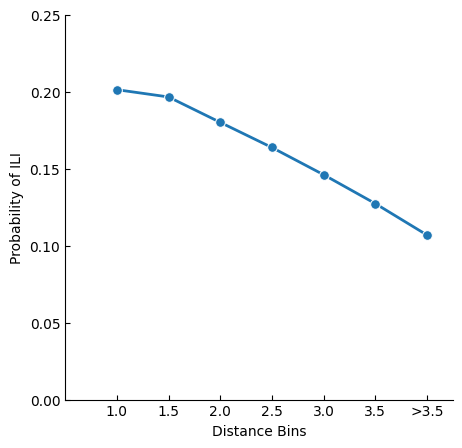

In [57]:
# ILI by distance bin
fig,ax = plt.subplots(figsize=(5,5))
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_ILI_distance, x='distance_bin', y='ILI_prob', linewidth=2, marker='o', markersize = 7)
plt.ylim([0,0.25])
plt.xlim([-1,6.5])
plt.xlabel('Distance Bins')
plt.ylabel('Probability of ILI')
plt.savefig('fig/simu8_ILI_distance.pdf')
plt.show()